# Masinsko ucenje, 3. projekat
Sanja Milenkovic 1549

dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction?resource=download

In [150]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from mlxtend.plotting import plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

from statistics import mean
from scipy.stats import uniform

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as kr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import recall_score

from sklearn.model_selection import cross_val_score, KFold

import warnings
warnings.filterwarnings('ignore')

In [151]:
dataset = pd.read_csv('heart.csv')
dataset.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [152]:
dataset.shape

(918, 12)

1. Priprema podataka

In [153]:
dataset.count()

Age               918
Sex               918
ChestPainType     918
RestingBP         918
Cholesterol       918
FastingBS         918
RestingECG        918
MaxHR             918
ExerciseAngina    918
Oldpeak           918
ST_Slope          918
HeartDisease      918
dtype: int64

In [154]:
dataset.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Zakljucak: nema praznih polja u datasetu

In [155]:
duplicates = dataset.duplicated()
print('Number of duplicates', duplicates.sum())

Number of duplicates 0


In [156]:
class_atribute = dataset['HeartDisease']

<Axes: xlabel='HeartDisease'>

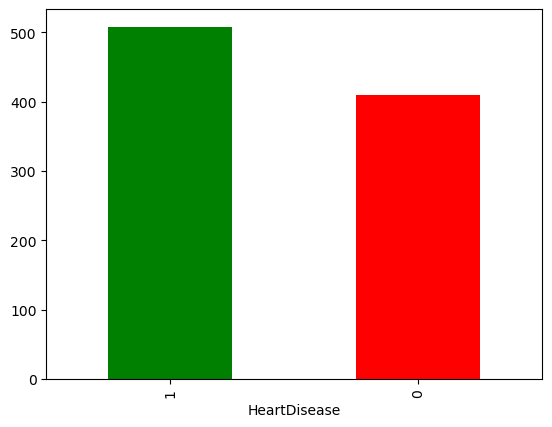

In [157]:
class_atribute.value_counts().plot(kind="bar", color=['green', 'red'])

In [158]:
dataset.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>,
        <Axes: title={'center': 'Cholesterol'}>],
       [<Axes: title={'center': 'FastingBS'}>,
        <Axes: title={'center': 'MaxHR'}>,
        <Axes: title={'center': 'Oldpeak'}>],
       [<Axes: title={'center': 'HeartDisease'}>, <Axes: >, <Axes: >]],
      dtype=object)

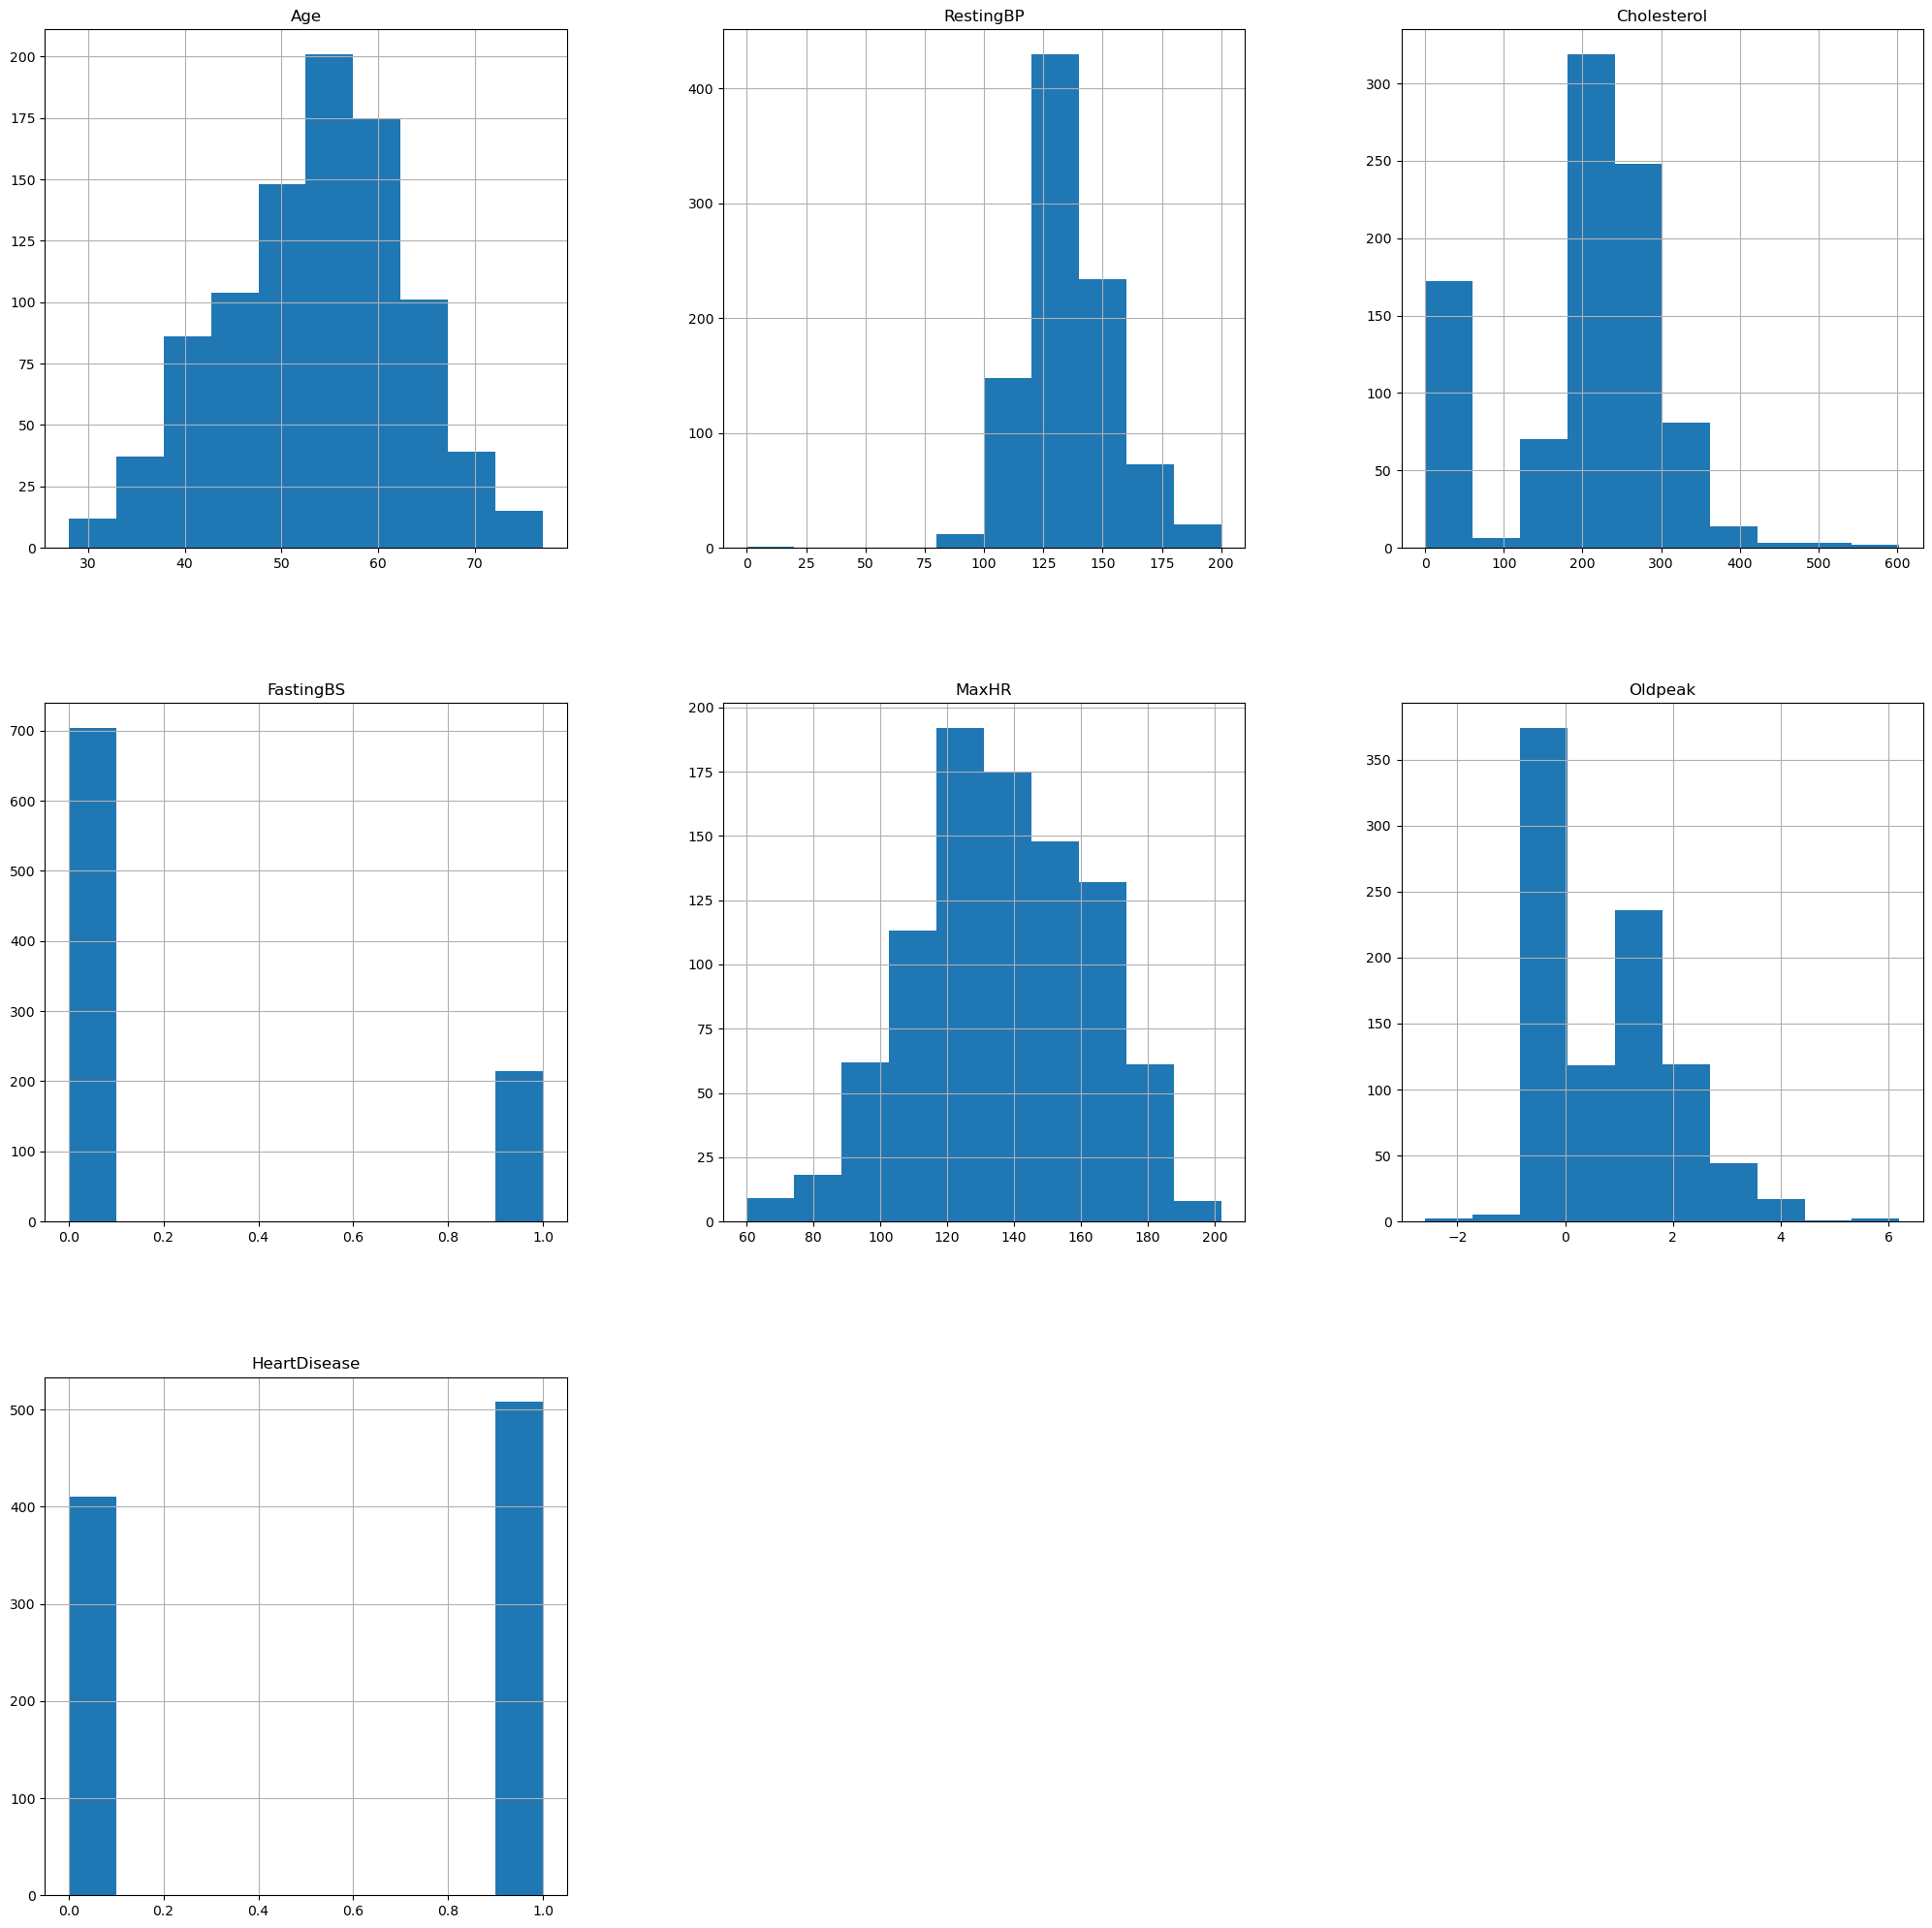

In [159]:
dataset.hist(figsize = (25,25))

In [160]:
label_encoder = preprocessing.LabelEncoder() 

dataset['Sex'] = label_encoder.fit_transform(dataset['Sex'])
dataset['ChestPainType'] = label_encoder.fit_transform(dataset['ChestPainType'])
dataset['RestingECG'] = label_encoder.fit_transform(dataset['RestingECG'])
dataset['ExerciseAngina'] = label_encoder.fit_transform(dataset['ExerciseAngina'])
dataset['ST_Slope'] = label_encoder.fit_transform(dataset['ST_Slope'])

In [161]:
dataset

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


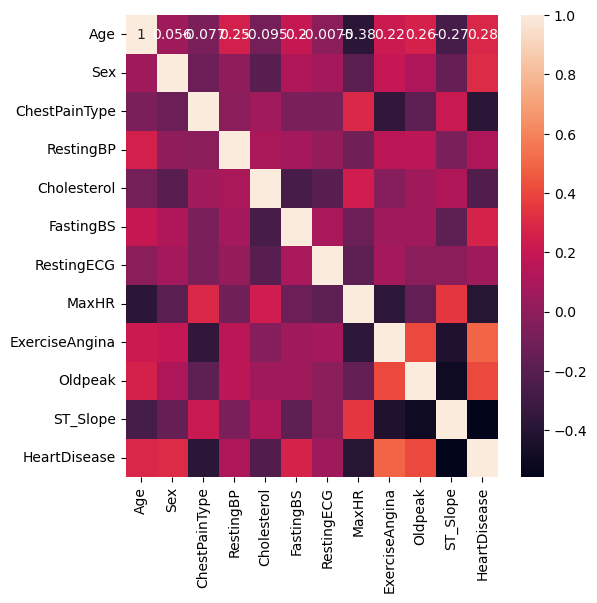

In [192]:
corr = dataset.corr()
plt.subplots(figsize=(6, 6))
sn.heatmap(corr, annot=True)
plt.show()

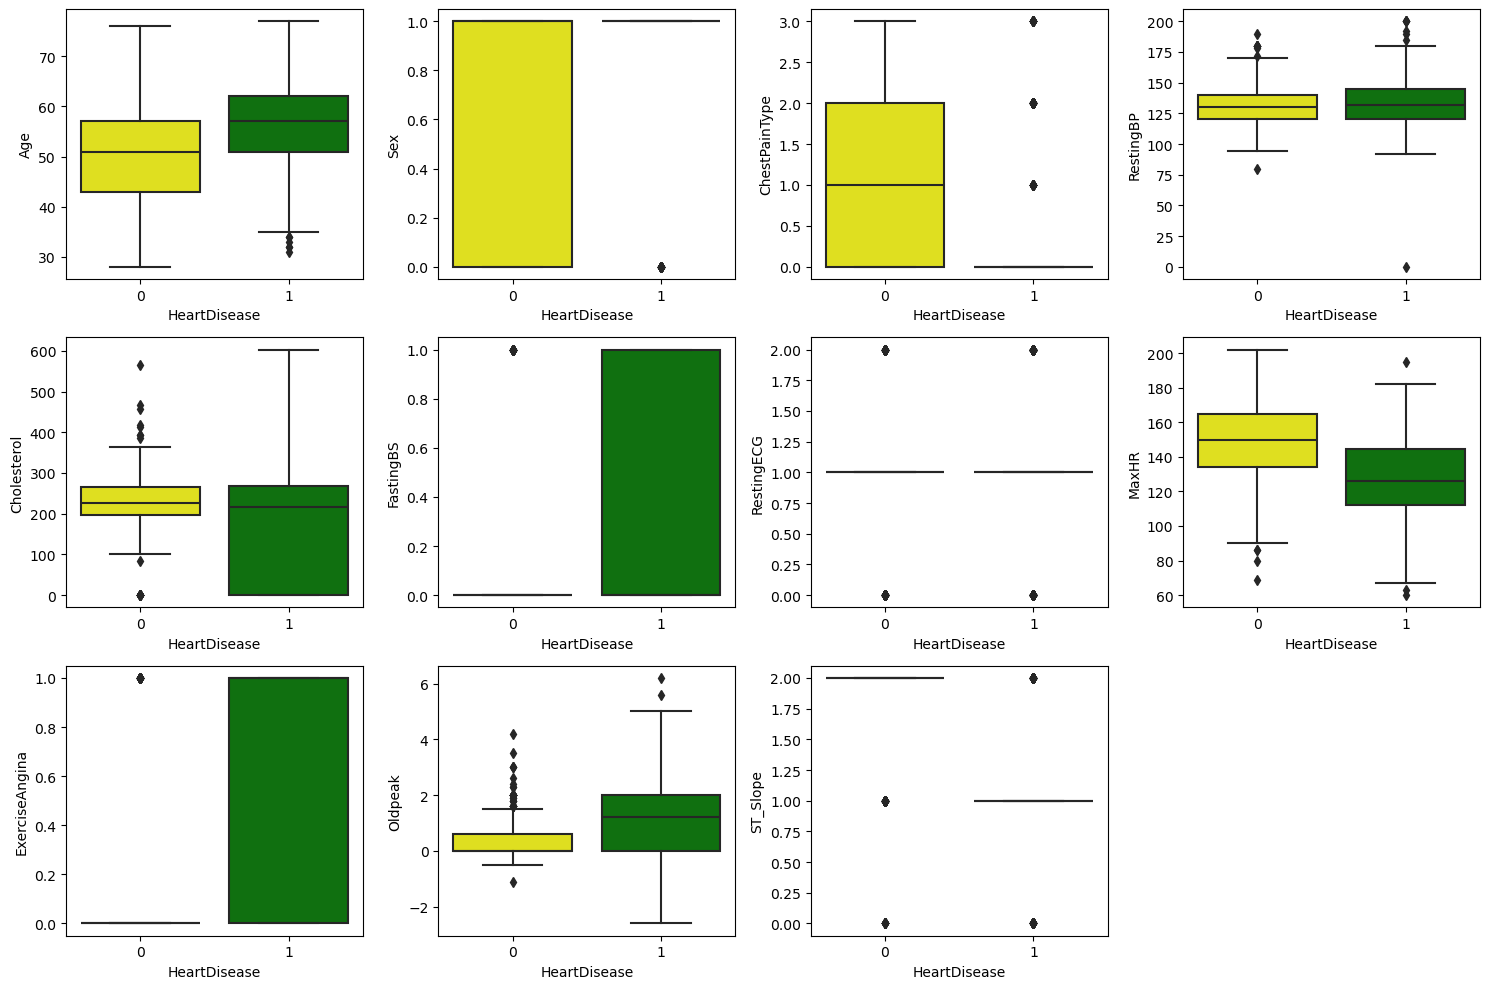

In [163]:
plt.figure(figsize=(15, 10))

num_cols = len(dataset.columns[:-1])
num_rows = (num_cols + 3) // 4  # Calculate number of rows dynamically

for i, column in enumerate(dataset.columns[:-1]):
    plt.subplot(num_rows, min(4, num_cols), i+1)  # Adjusting the number of columns per row
    sn.boxplot(x=dataset["HeartDisease"], y=dataset[column], palette=("yellow", "green"))
    plt.tight_layout()

plt.show()

In [164]:
def remove_outliers(dataset, column_names, th1=0.25, th3=0.75):
    dataset_no_outliers = dataset.copy()  # Make a copy of the dataset to avoid modifying the original

    for column_name in column_names:
        # Extract the specified feature
        feature = dataset_no_outliers[column_name]

        q11 = feature.quantile(th1)
        q33 = feature.quantile(th3)

        # Calculate quartiles and IQR
        iqr = q33 - q11
        lower_bound = q11 - (iqr * 1.5)
        upper_bound = q33 + (iqr * 1.5)

        # Identify outliers
        boolean_outliers = (feature > upper_bound) | (feature < lower_bound)

        # Remove outliers from the dataset
        dataset_no_outliers = dataset_no_outliers[~boolean_outliers]

    return dataset_no_outliers

In [165]:
def determine_outlier_thresholds_std(dataframe, col_name):
    upper_boundary = dataframe[col_name].mean() + 2 * dataframe[col_name].std()
    lower_boundary = dataframe[col_name].mean() - 2 * dataframe[col_name].std()
    return lower_boundary, upper_boundary

In [166]:
def remove_ouliers_standard_deviation (dataset, column_names) :
    no_copy = dataset.copy()

    for column in column_names :
        lb, ub = determine_outlier_thresholds_std(dataset, column)
        outliers = (dataset[column] > ub) | (dataset[column] < lb)
        no_copy = no_copy[~outliers]

    return no_copy

In [167]:
dataset_without_outliers = remove_outliers(dataset, dataset.columns)
dataset_without_outliers

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
4,54,1,2,150,195,0,1,122,0,0.0,2,0
5,39,1,2,120,339,0,1,170,0,0.0,2,0
7,54,1,1,110,208,0,1,142,0,0.0,2,0
8,37,1,0,140,207,0,1,130,1,1.5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
907,44,1,0,120,169,0,1,144,1,2.8,0,1
910,41,1,1,120,157,0,1,182,0,0.0,2,0
913,45,1,3,110,264,0,1,132,0,1.2,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1


In [168]:
dataset_std_outliers = remove_ouliers_standard_deviation(dataset, dataset.columns)
dataset_std_outliers

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
911,59,1,0,164,176,1,0,90,0,1.0,1,1
912,57,0,0,140,241,0,1,123,1,0.2,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


# Test and train data 

In [169]:
def split_test_and_train_data (dataset) : 

    x = dataset.drop('HeartDisease', axis=1).values
    y = dataset['HeartDisease'].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

    return x_train, x_test, y_train, y_test

In [170]:
def scale_test_and_train_data(x_train, x_test): 
    sc = StandardScaler()

    x_train = sc.fit_transform(x_train)
    x_test = sc.fit_transform(x_test)

    return x_train, x_test

In [171]:
x_train, x_test, y_train, y_test = split_test_and_train_data(dataset)
x_train, x_test = scale_test_and_train_data(x_train, x_test)

print('Num of train instances:', len(x_train))
print('Num of test instances:', len(x_test))

Num of train instances: 734
Num of test instances: 184


In [172]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = split_test_and_train_data(dataset_std_outliers)
x_train_scaled, x_test_scaled = scale_test_and_train_data(x_train_scaled, x_test_scaled)

print('Num of train instances:', len(x_train_scaled))
print('Num of test instances:', len(x_test_scaled))

Num of train instances: 570
Num of test instances: 143


In [196]:
unique_values, counts = np.unique(y_test_scaled, return_counts=True)
print(unique_values)
print(counts)

[0 1]
[71 72]


In [197]:
unique_values, counts = np.unique(y_train_scaled, return_counts=True)
print(unique_values)
print(counts)

[0 1]
[270 300]


# #1

In [173]:
def show_hist(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [174]:
def get_pred_labels(ann, X_test):
  y_pred = ann.predict(X_test)
  for i in range(len(y_pred)):
    y_pred[i] = 1 if (y_pred[i] > 0.5) else 0
  y_pred = np.concatenate(y_pred, axis=0).astype(int)
  return y_pred

In [175]:
def show_conf_matrix(y_pred):
  cm = confusion_matrix(y_test.astype(int), y_pred.astype(int))
  plt.figure()
  plot_confusion_matrix(cm, figsize=(5,5), hide_ticks=True, cmap=plt.cm.Reds)
  plt.xticks(range(2), ['NO', 'YES'], fontsize=16)
  plt.yticks(range(2), ['NO', 'YES'], fontsize=16)
  plt.show()

In [176]:
ann1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=12, activation='relu'), # Input layer
    tf.keras.layers.Dense(units=12, activation='relu'), # Hidden layer
    tf.keras.layers.Dense(units=1, activation='sigmoid') # Output layer
])

ann1.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", 
                                                  patience=3)

In [177]:
BATCH_SIZE = 32
EPOCHS = 50

ann1_history = ann1.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(x_test, y_test))
ann1_prediction = ann1.predict(x_test)

ann1_pred_labels = get_pred_labels(ann1, x_test)

Epoch 1/50
23/23 [==============================] - 3s 34ms/step - loss: 0.7122 - accuracy: 0.5409 - val_loss: 0.6047 - val_accuracy: 0.7283
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 0.6224 - accuracy: 0.6880 - val_loss: 0.5300 - val_accuracy: 0.8533
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 0.5572 - accuracy: 0.7684 - val_loss: 0.4714 - val_accuracy: 0.8750
Epoch 4/50
23/23 [==============================] - 0s 10ms/step - loss: 0.5043 - accuracy: 0.8106 - val_loss: 0.4224 - val_accuracy: 0.8859
Epoch 5/50
23/23 [==============================] - 0s 11ms/step - loss: 0.4631 - accuracy: 0.8161 - val_loss: 0.3868 - val_accuracy: 0.8750
Epoch 6/50
23/23 [==============================] - 0s 13ms/step - loss: 0.4336 - accuracy: 0.8174 - val_loss: 0.3608 - val_accuracy: 0.8750
Epoch 7/50
23/23 [==============================] - 0s 10ms/step - loss: 0.4124 - accuracy: 0.8174 - val_loss: 0.3442 - val_accuracy: 0.8750
Epoch 8/50
23/

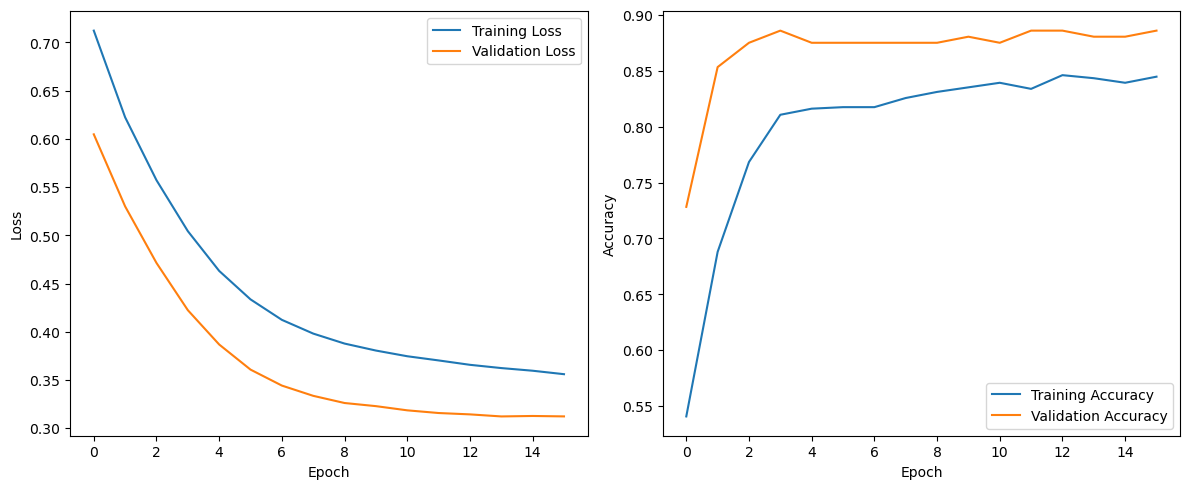

In [178]:
show_hist(ann1_history)

<Figure size 640x480 with 0 Axes>

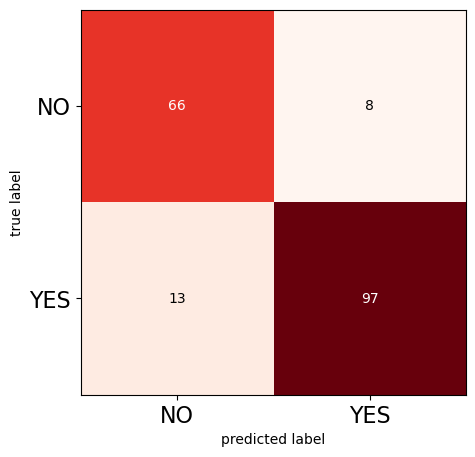

In [179]:
show_conf_matrix(ann1_pred_labels)

In [180]:
print(classification_report(y_test.astype(int), ann1_pred_labels.astype(int)))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        74
           1       0.92      0.88      0.90       110

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184



Isti postupak sa skaliranim datasetom

In [181]:
BATCH_SIZE = 16
EPOCHS = 50

ann1_history_scaled = ann1.fit(x_train_scaled, y_train_scaled, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(x_test_scaled, y_test_scaled))
ann1_prediction_scaled = ann1.predict(x_test_scaled)

ann1_pred_labels_scaled = get_pred_labels(ann1, x_test_scaled)

Epoch 1/50
36/36 [==============================] - 1s 18ms/step - loss: 0.3115 - accuracy: 0.8737 - val_loss: 0.3944 - val_accuracy: 0.8112
Epoch 2/50
36/36 [==============================] - 0s 9ms/step - loss: 0.3017 - accuracy: 0.8719 - val_loss: 0.4021 - val_accuracy: 0.8112
Epoch 3/50
36/36 [==============================] - 0s 9ms/step - loss: 0.2932 - accuracy: 0.8754 - val_loss: 0.4029 - val_accuracy: 0.8042
Epoch 4/50
36/36 [==============================] - 0s 8ms/step - loss: 0.2873 - accuracy: 0.8789 - val_loss: 0.4080 - val_accuracy: 0.8182
Epoch 5/50
36/36 [==============================] - 0s 11ms/step - loss: 0.2824 - accuracy: 0.8807 - val_loss: 0.4144 - val_accuracy: 0.8182
Epoch 6/50
36/36 [==============================] - 0s 8ms/step - loss: 0.2773 - accuracy: 0.8825 - val_loss: 0.4154 - val_accuracy: 0.8182
Epoch 7/50
36/36 [==============================] - 0s 8ms/step - loss: 0.2724 - accuracy: 0.8825 - val_loss: 0.4178 - val_accuracy: 0.8112
Epoch 8/50
36/36 [

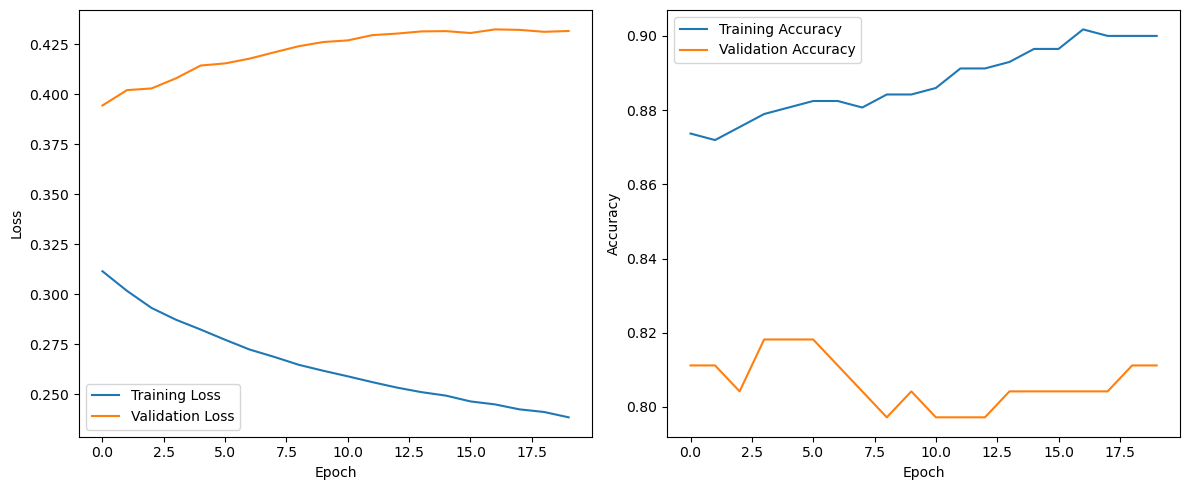

In [182]:
show_hist(ann1_history_scaled)

<Figure size 640x480 with 0 Axes>

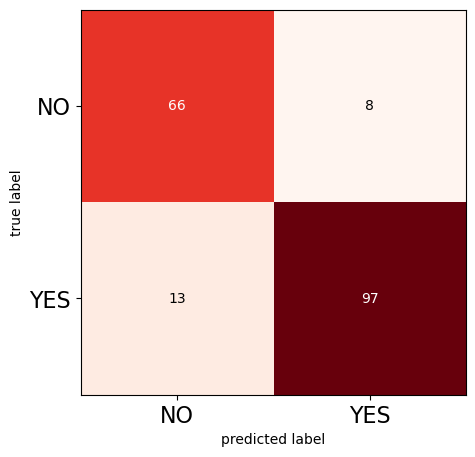

In [183]:
show_conf_matrix(ann1_pred_labels)

In [184]:
print(classification_report(y_test_scaled.astype(int), ann1_pred_labels_scaled.astype(int)))

              precision    recall  f1-score   support

           0       0.87      0.73      0.79        71
           1       0.77      0.89      0.83        72

    accuracy                           0.81       143
   macro avg       0.82      0.81      0.81       143
weighted avg       0.82      0.81      0.81       143



# #2

In [185]:
ann2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=30, activation='relu'), # Input layer and 1st Hidden layer
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=16, activation='relu'), # 2nd Hidden layer
    tf.keras.layers.Dropout(rate=0.1), 
    tf.keras.layers.Dense(units=1, activation='sigmoid') # Output layer
])

ann2.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", 
                                                  patience=3)

In [186]:
BATCH_SIZE = 32
EPOCHS = 50

ann2_history = ann2.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(x_test, y_test))
ann2_prediction = ann2.predict(x_test)

ann2_pred_labels = get_pred_labels(ann2, x_test)

Epoch 1/50
23/23 [==============================] - 3s 40ms/step - loss: 0.5702 - accuracy: 0.7439 - val_loss: 0.5115 - val_accuracy: 0.8207
Epoch 2/50
23/23 [==============================] - 0s 11ms/step - loss: 0.5091 - accuracy: 0.7902 - val_loss: 0.4421 - val_accuracy: 0.8424
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 0.4633 - accuracy: 0.8147 - val_loss: 0.3932 - val_accuracy: 0.8424
Epoch 4/50
23/23 [==============================] - 0s 11ms/step - loss: 0.4262 - accuracy: 0.8161 - val_loss: 0.3618 - val_accuracy: 0.8696
Epoch 5/50
23/23 [==============================] - 0s 11ms/step - loss: 0.4135 - accuracy: 0.8324 - val_loss: 0.3445 - val_accuracy: 0.8804
Epoch 6/50
23/23 [==============================] - 0s 8ms/step - loss: 0.4018 - accuracy: 0.8406 - val_loss: 0.3391 - val_accuracy: 0.8804
Epoch 7/50
23/23 [==============================] - 0s 10ms/step - loss: 0.3968 - accuracy: 0.8338 - val_loss: 0.3301 - val_accuracy: 0.8804
Epoch 8/50
23/

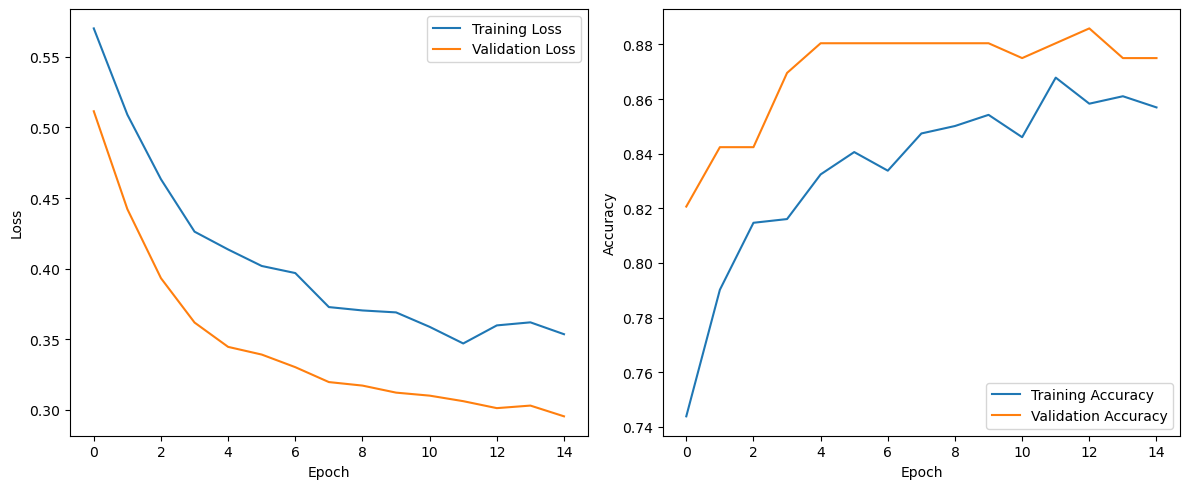

In [187]:
show_hist(ann2_history)

<Figure size 640x480 with 0 Axes>

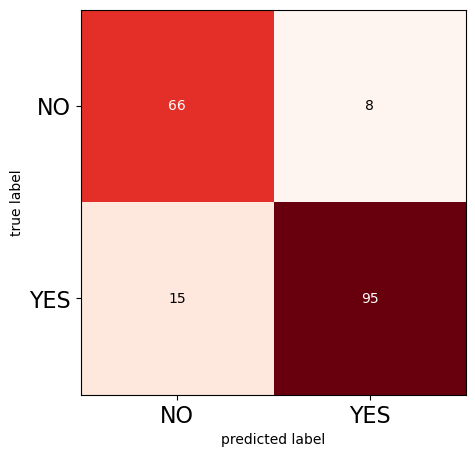

In [188]:
show_conf_matrix(ann2_pred_labels)

In [189]:
print(classification_report(y_test.astype(int), ann2_pred_labels.astype(int)))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        74
           1       0.92      0.86      0.89       110

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.87       184
weighted avg       0.88      0.88      0.88       184



In [198]:
BATCH_SIZE = 32
EPOCHS = 50

ann2_history_scaled = ann1.fit(x_train_scaled, y_train_scaled, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(x_test_scaled, y_test_scaled))
ann2_prediction_scaled = ann1.predict(x_test_scaled)

ann2_pred_labels_scaled = get_pred_labels(ann1, x_test_scaled)

Epoch 1/50
18/18 [==============================] - 1s 29ms/step - loss: 0.2293 - accuracy: 0.9035 - val_loss: 0.4321 - val_accuracy: 0.8182
Epoch 2/50
18/18 [==============================] - 0s 13ms/step - loss: 0.2284 - accuracy: 0.9035 - val_loss: 0.4307 - val_accuracy: 0.8182
Epoch 3/50
18/18 [==============================] - 0s 10ms/step - loss: 0.2273 - accuracy: 0.9035 - val_loss: 0.4297 - val_accuracy: 0.8182
Epoch 4/50
5/5 [==============================] - 0s 4ms/step


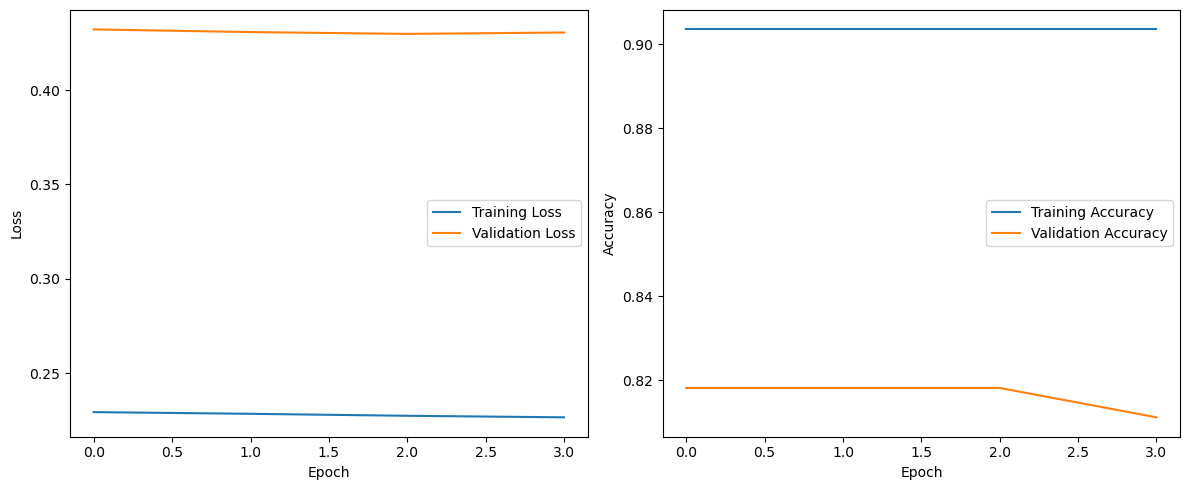

In [199]:
show_hist(ann2_history_scaled)

In [201]:
print(classification_report(y_test_scaled.astype(int), ann2_pred_labels_scaled.astype(int)))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80        71
           1       0.78      0.88      0.82        72

    accuracy                           0.81       143
   macro avg       0.82      0.81      0.81       143
weighted avg       0.82      0.81      0.81       143

